In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

/home/biel/anaconda2/envs/py35/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


# Creixement listings 

In [2]:
data = pd.read_csv('listings_clean.csv')
data['host_since'] = pd.to_datetime(data['host_since'], format="%Y-%m-%d")
data['host_timing']=np.ones(len(data))
list_count = data.host_timing.groupby(data.host_since).sum()

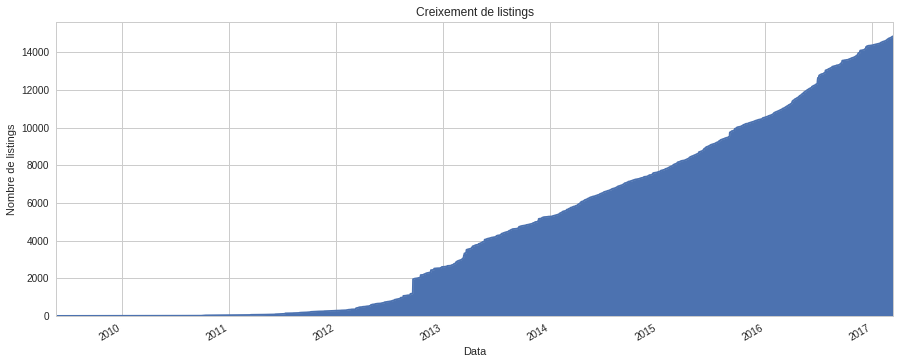

In [3]:
list_grow = list_count.cumsum()
list_grow.plot(kind='area')
plt.title('Creixement de listings')
plt.ylabel('Nombre de listings')
plt.xlabel('Data')

### Resamplig a cada mes

Possiblement necessàri  pel model de forecasting

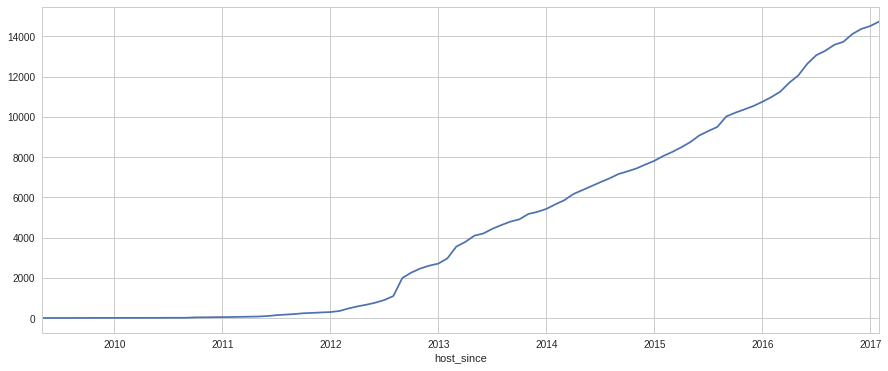

In [4]:
grow_res=list_grow.resample('1m').bfill()
grow_res.dropna(inplace=True)
grow_res.plot()

# Creixement Hosts 

In [5]:
host_grow = data[['host_since', 'host_id']]
host_grow = host_grow.drop_duplicates(['host_id'])
host_grow['counts'] = np.ones(len(host_grow))

host_grow.sort_values(['host_since'], inplace=True)
host_grow=host_grow.reset_index(drop=True)

host_grow = host_grow.counts.groupby(host_grow.host_since).sum()
host_grow = host_grow.cumsum()

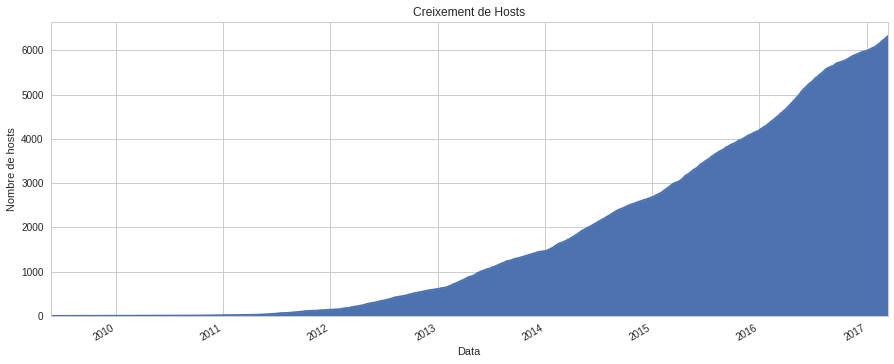

In [6]:
host_grow.plot(kind='area')
plt.title('Creixement de Hosts')
plt.ylabel('Nombre de hosts')
plt.xlabel('Data')

### Plot de la proliferació de listings i hosts a la mateixa figura:

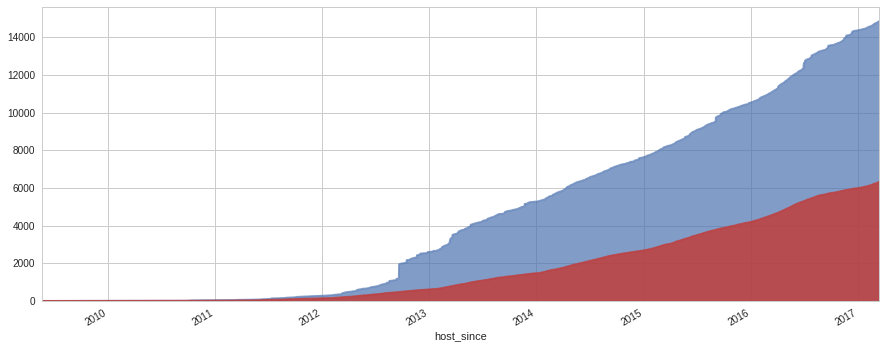

In [7]:
list_grow.plot(kind='area', alpha=0.7)
host_grow.plot(kind='area', alpha=0.8, color='#c43733')

la proliferació de hostings i listings no augmenten al mateix rimte

Ratio entre nº listings i nº hosts:

In [8]:
ratio = list_grow/host_grow

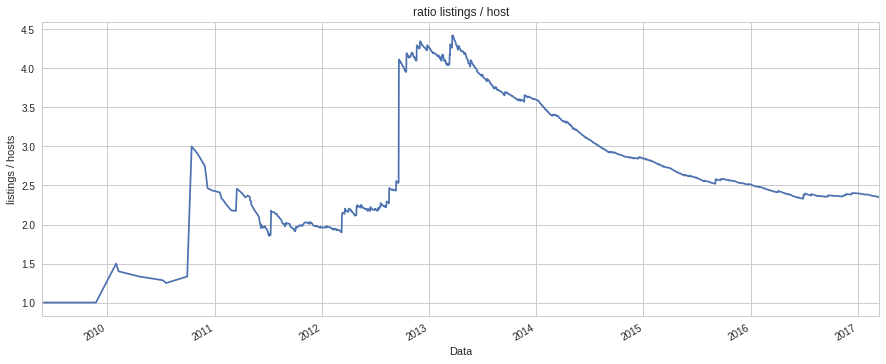

In [9]:
ratio.plot()
plt.title('ratio listings / host')
plt.ylabel('listings / hosts')
plt.xlabel('Data')

# Forecasting

<div class='alert alert-warning'>
**TO DO**: Forecasting amb facebook Prophet de les tendències de proliferació tan de listings com de hostings
</div>

comprovam la ciclicitat. Codi de https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

## Ciclicitat de la proliferació de listings

In [11]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window,center=False).mean()
    rolstd = timeseries.rolling(window=window,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original', linewidth=0.8)
    mean = plt.plot(rolmean, color='red', label='Rolling Mean', linewidth=0.8)
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

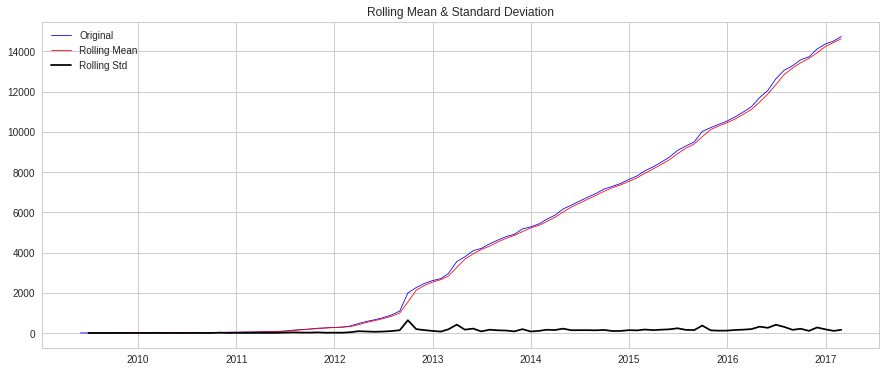

Results of Dickey-Fuller Test:
Test Statistic                  3.390189
p-value                         1.000000
#Lags Used                      1.000000
Number of Observations Used    92.000000
Critical Value (1%)            -3.503515
Critical Value (5%)            -2.893508
Critical Value (10%)           -2.583824
dtype: float64


In [12]:
test_stationarity(grow_res,2)

/home/biel/anaconda2/envs/py35/lib/python3.5/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


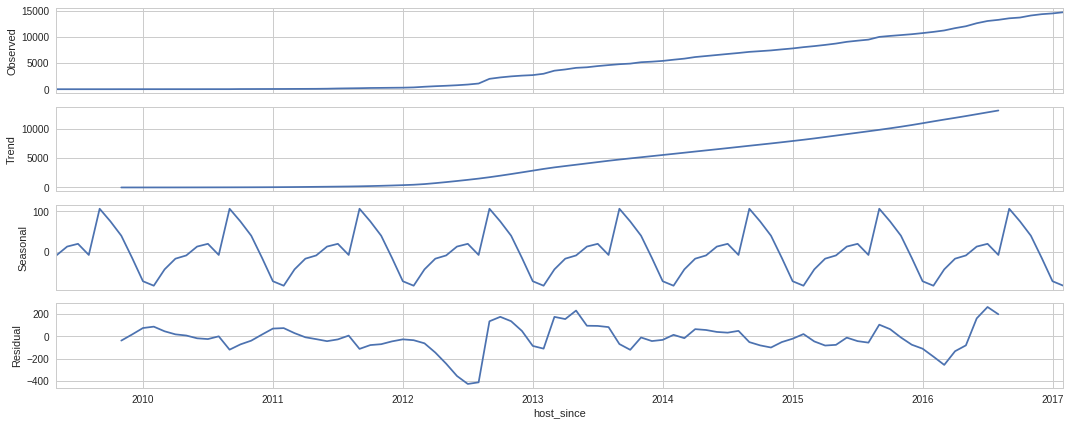

In [13]:
decomposition = seasonal_decompose(grow_res)  
fig = plt.figure()  
fig = decomposition.plot()  

## Ciclicitat de la proliferació de hostings

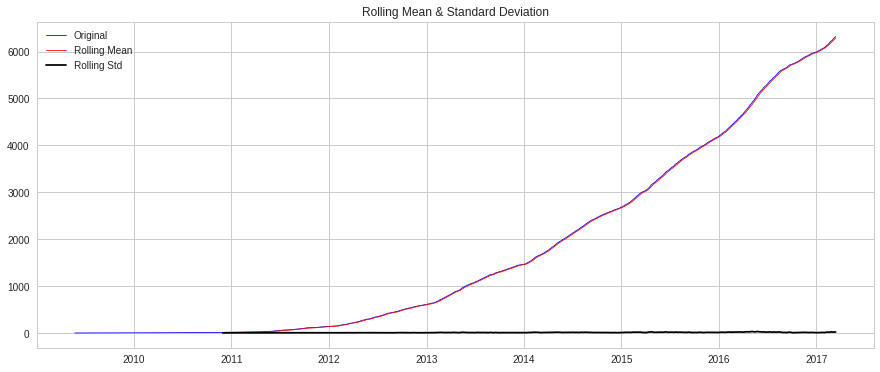

Results of Dickey-Fuller Test:
Test Statistic                    2.984069
p-value                           1.000000
#Lags Used                       15.000000
Number of Observations Used    1810.000000
Critical Value (1%)              -3.433968
Critical Value (5%)              -2.863138
Critical Value (10%)             -2.567621
dtype: float64


In [14]:
test_stationarity(host_grow,12)

/home/biel/anaconda2/envs/py35/lib/python3.5/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


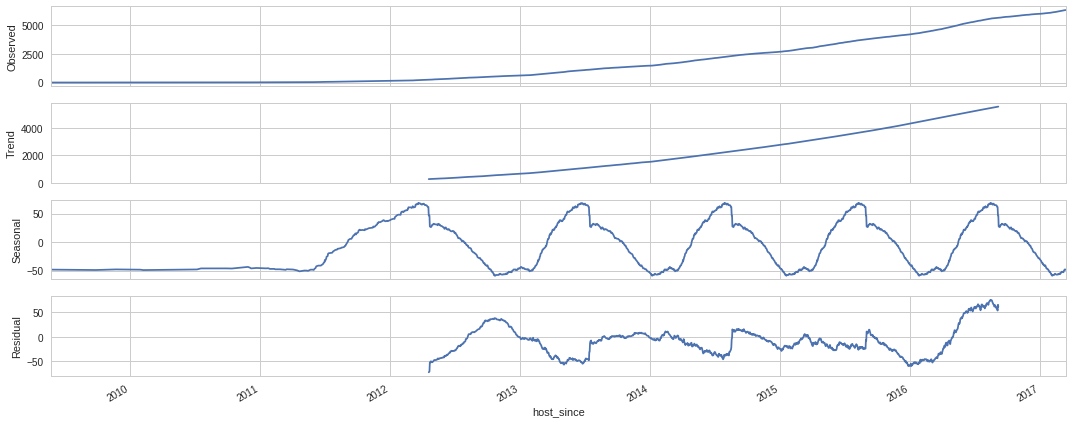

In [15]:
decomposition = seasonal_decompose(host_grow, freq=365)#frequència anual
fig = plt.figure()  
fig = decomposition.plot()  

## Forescasting with prophet
### Host forecasting

In [16]:
from fbprophet import Prophet

In [44]:
df_fore = pd.DataFrame(columns=('ds', 'y'))
df_fore.ds = host_grow.index
df_fore.y = host_grow.values

In [46]:
m = Prophet()

In [47]:
m.fit(df_fore)

In [56]:
future = m.make_future_dataframe(periods=550)
future.tail()

,ds
2371,2018-09-11
2372,2018-09-12
2373,2018-09-13
2374,2018-09-14
2375,2018-09-15


In [57]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2371,2018-09-11,9130.299269,8093.833540,10188.936970
2372,2018-09-12,9133.572991,8077.630771,10185.168493
2373,2018-09-13,9137.060846,8094.359893,10210.358050
2374,2018-09-14,9140.362880,8079.646088,10217.702334
2375,2018-09-15,9143.693088,8099.641363,10211.756736


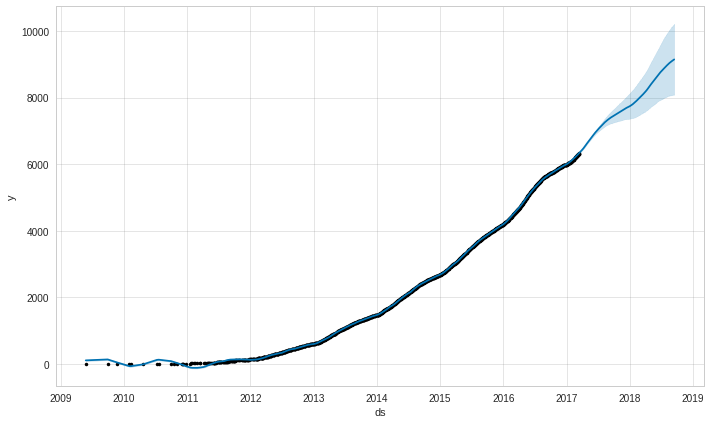

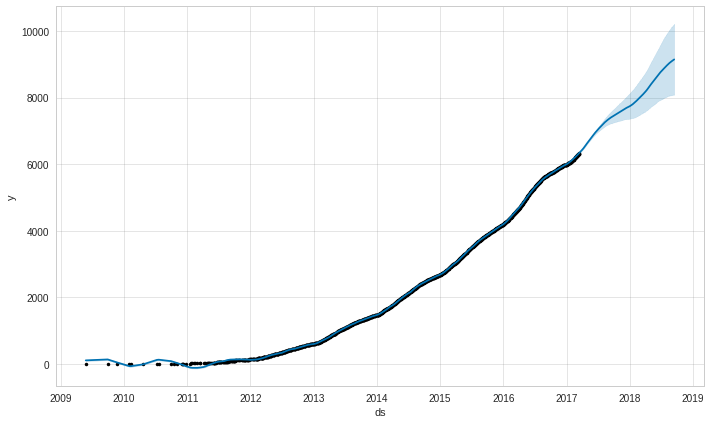

In [58]:
m.plot(forecast)

### Listings forecasting

In [59]:
df_fore = pd.DataFrame(columns=('ds', 'y'))
df_fore.ds = list_grow.index
df_fore.y = list_grow.values

In [60]:
m.fit(df_fore)

In [61]:
future = m.make_future_dataframe(periods=550)
future.tail()

,ds
2371,2018-09-11
2372,2018-09-12
2373,2018-09-13
2374,2018-09-14
2375,2018-09-15


In [62]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2371,2018-09-11,20985.462076,17885.115550,23748.547203
2372,2018-09-12,21001.228697,17954.183003,23731.931717
2373,2018-09-13,21019.373246,17918.901196,23780.758468
2374,2018-09-14,21036.139384,17918.604214,23794.701634
2375,2018-09-15,21052.481589,17918.866061,23837.472178


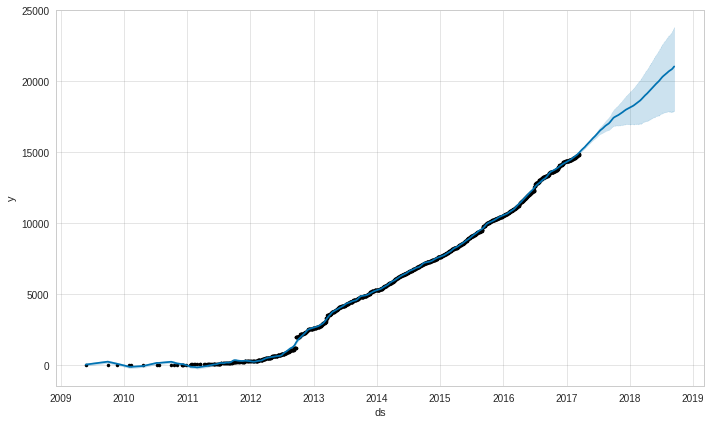

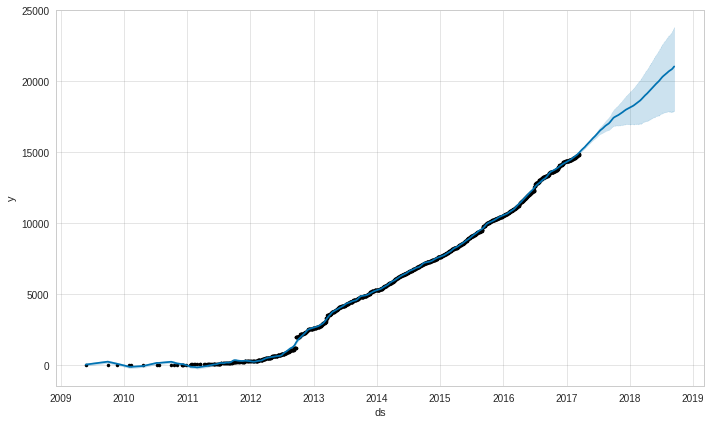

In [63]:
m.plot(forecast)